# Deep Learning
#### Virtual Adversarial Training

VAT is semi-supervised learning method, which help us solves the real problem: most of data is unlabeled. With only small amout of labeled data and a large amount of unlabeled data, VAT can build a robust model.

We will performce the VAT method on MNIST data with only 100 labels and 59900 unlabels, and testing the accuracy of the model on test set 10000 observations.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pydot

%matplotlib inline

In [ ]:
from tqdm import tqdm
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Input, Dense, GaussianNoise, BatchNormalization, Dropout, ReLU, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds

In [ ]:
tf.keras.backend.set_floatx('float64')

#### Loading data MNIST

In [ ]:
from keras.datasets import mnist

(x_train_original, y_train_original), (x_test, y_test) = mnist.load_data()
x_train = x_train_original/255
x_test = x_test/255
num_classes = y_train_original.max() +1
y_train = to_categorical(y_train_original, num_classes)
y_test = to_categorical(y_test, num_classes)

#### Splitting data: 100 labels and 59900 unlabels

In [ ]:
from sklearn.model_selection import train_test_split
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(x_train, y_train, test_size=59900, random_state=42, shuffle= True,stratify=y_train)

## Adversarial Training and Virtual Adversarial Training

In adversarial training, we augment the loss function by the adversarial perturbation loss, which can be considered as the regulization term. 

The pertubation loss is defind by divergence between two distributions $q(y|x)$ the true distribution of data and $p(y|x+r_{adv},\theta)$ the prediction of model with a small adversarial perturbation $r_{adv} (\| r\| _2\le\epsilon ).$ 
$$L(x,\theta) = D(q(y|x),p(y|x+r_{adv},\theta))$$
$$r_{adv} = \underset{r}{\operatorname{argmax}} \{KL(r,x,\theta);\| r\| _2\le\epsilon \}$$

Some examples of function D: cross entropy, Kullback divergence

In case of semi-supervised, we have large amount of unlabeleds data whose $q(y|x)$ is unknown. VAT propose replace $q(y|x)$ by recent prediction of model $p(y|x,\theta)$. The perturbation loss in VAT is defined below:

$$LDS(x,\theta) = D(p(y|x,\theta),p(y|x+r_{vadv},\theta))$$
$$r_{vadv} = \underset{r}{\operatorname{argmax}} \{D(x,\theta);\| r\| _2\le\epsilon \}$$

And VAT's loss function:
$$l(D_l,\theta) + \alpha R_{vadv}(D_l,D_ul,\theta)$$
With $l(D_l,\theta)$ is loss function on labeled data set (i.e. cross entropy loss) and $R_{vadv}(D_l,D_ul,\theta)$ average of pertubation loss over all input data.

#### Used functions

Baseline model: 4 layers neural network (1200, 600, 300, 150 units) with Gaussian noise and Batch normalization.

In [ ]:
def MLP():
    network = Sequential()

    network.add(Flatten(input_shape=(28,28)))
    network.add(Dense(1200,input_shape=(784,)))
    network.add(GaussianNoise(0.5))
    network.add(BatchNormalization())
    network.add(ReLU())
    #network.add(Dropout(0.25))

    network.add(Dense(600))
    network.add(GaussianNoise(0.5))
    network.add(BatchNormalization())
    network.add(ReLU())
    #network.add(Dropout(0.25))

    network.add(Dense(300))
    network.add(GaussianNoise(0.5))
    network.add(BatchNormalization())
    network.add(ReLU())
    #network.add(Dropout(0.25))

    network.add(Dense(150))
    network.add(GaussianNoise(0.5))
    network.add(BatchNormalization())
    network.add(ReLU())
    #network.add(Dropout(0.25))

    network.add(Dense(10))
    
    return network

Calculation of perturbation term $r_{vadv}$ by current values of parameters of neural network.

In [ ]:
def normalization(d):
    d = d/(1e-15 + tf.reduce_max(tf.abs(d), range(1, len(d.get_shape())), keepdims=True))
    norm_d = tf.norm(d+1e-15,axis=[1,2])
    return (d+1e-15) / tf.reshape(norm_d, [d.shape[0],1,1])

def generator(x, xi):
    r = xi * normalization(tf.random.normal(shape=tf.shape(x), dtype=tf.float64))
    with tf.GradientTape() as tape:
        tape.watch(r)
        p_logit = network(x)
        p_logit_r = network(x + r)
        kl = tf.reduce_mean(KL_divergence(p_logit , p_logit_r))
    grad = tape.gradient(kl, r)
    return x + epsilon * normalization(grad)

Calculation of loss function

In [ ]:
def KL_divergence(p_logit, q_logit, value_min = 1e-30):
    p = tf.nn.softmax(p_logit)
    q = tf.nn.softmax(q_logit)
    return tf.reduce_sum(p*(tf.math.log(p + value_min) - tf.math.log(q + value_min)), axis=1)

def pertubation_loss(logit_p, logit_p_r):
    return tf.reduce_mean(KL_divergence(logit_p, logit_p_r))
    
def cross_entropy_loss(y_labeled, logit_labeled):
    return tf.keras.losses.CategoricalCrossentropy(y_true=y_labeled, y_pred=logit_labeled, from_logits=True)

def vat_loss(logit_p, logit_p_r, y_labeled, logit_labeled, alpha = 1):
    return pertubation_loss(logit_p, logit_p_r) * alpha + cross_entropy_loss(y_labeled, logit_labeled)

Traning setting: There are 2 hyper-parameters $\epsilon$ and $\alpha$. We fix $\alpha = 1$ and find the best value of $\epsilon = 0.145$. We use Adam optimizer and decay learning rate linearly.

In [ ]:
network = MLP()
x_train = tf.constant(x_train, dtype = tf.float64)
x_labeled = tf.constant(x_labeled, dtype = tf.float64)
EPOCHS = 200
BATCH_SIZE = 256
BUFFER_SIZE = 60000
DISPLAY_STEP = 1
epsilon = 0.145
xi = 1e-6
alpha = 1
lnr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 0.0001, decay_steps=50000, end_learning_rate=0.0000001, power=1.0,
    cycle=False, name=None
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lnr)

In [ ]:
@tf.function
def train_step(x_train, x_labeled, y_labeled):
    x_gen = generator(x_train, xi)
    with tf.GradientTape() as tape:
        tape.watch(network.trainable_weights)
        
        logit_p = network(x_train)
        logit_p_r = network(x_gen)
        logit_labeled = network(x_labeled)
        
        loss = vat_loss(logit_p, logit_p_r, y_labeled, logit_labeled, alpha)
        
    grad = tape.gradient(loss, network.trainable_weights)

    optimizer.apply_gradients(zip(grad, network.trainable_weights))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Traning VAT

In [ ]:
Total_loss = []
Pertubation_loss = []
Cross_entropy_loss = []
Test_accuracy = []
Epoch = []

for epoch in tqdm(np.arange(0,EPOCHS)):
    for image_batch in train_dataset:
        train_step(image_batch, x_labeled, y_labeled)
        
    if (epoch % DISPLAY_STEP == 0 ) or epoch == 0 or (epoch==EPOCHS-1):
        x_gen = generator(x_train, xi)
        logit_p = network(x_train)
        logit_p_r = network(x_gen)
        logit_labeled = network(x_labeled)
    
        per_loss = pertubation_loss(logit_p, logit_p_r)
        cross_loss = cross_entropy_loss(y_labeled, logit_labeled)
        loss = vat_loss(logit_p, logit_p_r, y_labeled, logit_labeled, alpha)
    
        logit_test = network(x_test)
        test_acc = sum(np.argmax(logit_test, 1)-np.argmax(y_test,1)==0) / 10000
    
        Epoch = np.append(Epoch, epoch)
        Total_loss = np.append(Total_loss, loss.numpy())
        Pertubation_loss = np.append(Pertubation_loss, per_loss.numpy())
        Cross_entropy_loss = np.append(Cross_entropy_loss, cross_loss.numpy())
        Test_accuracy = np.append(Test_accuracy, test_acc)
    
        print(loss.numpy(), test_acc)

  0%|          | 1/200 [00:12<42:34, 12.84s/it]

0.01231715252928966 0.8199


  1%|          | 2/200 [00:21<38:33, 11.68s/it]

0.008803505023578132 0.8603


  2%|▏         | 3/200 [00:30<35:36, 10.84s/it]

0.007086748749407178 0.885


  2%|▏         | 4/200 [00:39<33:29, 10.25s/it]

0.006066183037242791 0.9007


  2%|▎         | 5/200 [00:48<31:58,  9.84s/it]

0.005338997551324355 0.9107


  3%|▎         | 6/200 [00:57<30:53,  9.56s/it]

0.004791462920616984 0.9165


  4%|▎         | 7/200 [01:06<30:06,  9.36s/it]

0.004426044293910525 0.924


  4%|▍         | 8/200 [01:15<29:31,  9.23s/it]

0.0040588507050435055 0.9314


  4%|▍         | 9/200 [01:24<29:03,  9.13s/it]

0.0038075306659766947 0.9326


  5%|▌         | 10/200 [01:32<28:39,  9.05s/it]

0.003537163641690968 0.9416


  6%|▌         | 11/200 [01:41<28:20,  9.00s/it]

0.0032835274832332065 0.9449


  6%|▌         | 12/200 [01:50<28:05,  8.97s/it]

0.003149330750217399 0.9472


  6%|▋         | 13/200 [01:59<27:51,  8.94s/it]

0.0030514600277715856 0.951


  7%|▋         | 14/200 [02:08<27:38,  8.92s/it]

0.002807282111888026 0.9567


  8%|▊         | 15/200 [02:17<27:27,  8.91s/it]

0.0026947035719955383 0.9566


  8%|▊         | 16/200 [02:26<27:19,  8.91s/it]

0.0026649843776410647 0.9558


  8%|▊         | 17/200 [02:35<27:08,  8.90s/it]

0.0025013338940908076 0.9602


  9%|▉         | 18/200 [02:44<26:58,  8.89s/it]

0.002398961244995642 0.9606


 10%|▉         | 19/200 [02:52<26:48,  8.88s/it]

0.002344101576308872 0.9643


 10%|█         | 20/200 [03:01<26:35,  8.86s/it]

0.0024241512459783022 0.9635


 10%|█         | 21/200 [03:10<26:26,  8.86s/it]

0.0021841794482259243 0.9671


 11%|█         | 22/200 [03:19<26:19,  8.87s/it]

0.0020661833115121118 0.9651


 12%|█▏        | 23/200 [03:28<26:08,  8.86s/it]

0.002039972111282123 0.9669


 12%|█▏        | 24/200 [03:37<26:02,  8.88s/it]

0.0019748458958516396 0.9687


 12%|█▎        | 25/200 [03:46<25:53,  8.88s/it]

0.0019776560570124524 0.9678


 13%|█▎        | 26/200 [03:54<25:46,  8.89s/it]

0.0018603179880315925 0.9698


 14%|█▎        | 27/200 [04:03<25:38,  8.90s/it]

0.0018535076415098302 0.9692


 14%|█▍        | 28/200 [04:12<25:29,  8.89s/it]

0.0018013391357446008 0.9701


 14%|█▍        | 29/200 [04:21<25:20,  8.89s/it]

0.0018850209540559808 0.9678


 15%|█▌        | 30/200 [04:30<25:13,  8.90s/it]

0.0017052533211897379 0.9703


 16%|█▌        | 31/200 [04:39<25:06,  8.91s/it]

0.0016229045039500795 0.9739


 16%|█▌        | 32/200 [04:48<24:54,  8.89s/it]

0.0016266414496879404 0.971


 16%|█▋        | 33/200 [04:57<24:43,  8.89s/it]

0.0015386747887072597 0.9724


 17%|█▋        | 34/200 [05:06<24:33,  8.87s/it]

0.0015340877717561455 0.9734


 18%|█▊        | 35/200 [05:15<24:26,  8.89s/it]

0.0015073036852789824 0.9729


 18%|█▊        | 36/200 [05:23<24:16,  8.88s/it]

0.0014164519520064782 0.9742


 18%|█▊        | 37/200 [05:32<24:07,  8.88s/it]

0.0014267962946864251 0.9728


 19%|█▉        | 38/200 [05:41<24:00,  8.89s/it]

0.0013426675280258887 0.9733


 20%|█▉        | 39/200 [05:50<23:53,  8.90s/it]

0.0013460509651913113 0.9752


 20%|██        | 40/200 [05:59<23:40,  8.88s/it]

0.0013149549050089462 0.9758


 20%|██        | 41/200 [06:08<23:34,  8.90s/it]

0.0011985705203425047 0.9776


 21%|██        | 42/200 [06:17<23:27,  8.91s/it]

0.0012601868789654757 0.9742


 22%|██▏       | 43/200 [06:26<23:14,  8.89s/it]

0.001241498327543097 0.9741


 22%|██▏       | 44/200 [06:35<23:07,  8.89s/it]

0.0011627438703065963 0.9747


 22%|██▎       | 45/200 [06:43<22:58,  8.90s/it]

0.0010811638652515783 0.9757


 23%|██▎       | 46/200 [06:52<22:48,  8.89s/it]

0.001035040272440373 0.9761


 24%|██▎       | 47/200 [07:01<22:39,  8.88s/it]

0.0009749101639185596 0.977


 24%|██▍       | 48/200 [07:10<22:30,  8.89s/it]

0.0009070015704765104 0.9778


 24%|██▍       | 49/200 [07:19<22:22,  8.89s/it]

0.000887392076167198 0.9777


 25%|██▌       | 50/200 [07:28<22:12,  8.89s/it]

0.0009025005145067683 0.9766


 26%|██▌       | 51/200 [07:37<22:05,  8.89s/it]

0.0008335376249981277 0.9778


 26%|██▌       | 52/200 [07:46<21:54,  8.88s/it]

0.0008646742846685702 0.9762


 26%|██▋       | 53/200 [07:55<21:46,  8.89s/it]

0.0007779633424409806 0.9778


 27%|██▋       | 54/200 [08:03<21:37,  8.88s/it]

0.0007205023258340615 0.9772


 28%|██▊       | 55/200 [08:12<21:29,  8.89s/it]

0.0006606323113064979 0.9775


 28%|██▊       | 56/200 [08:21<21:18,  8.88s/it]

0.0007584755086409336 0.977


 28%|██▊       | 57/200 [08:30<21:10,  8.89s/it]

0.00057603768255347 0.9772


 29%|██▉       | 58/200 [08:39<21:01,  8.88s/it]

0.0008662419418931966 0.9765


 30%|██▉       | 59/200 [08:48<20:54,  8.89s/it]

0.00048263681923467987 0.977


 30%|███       | 60/200 [08:57<20:47,  8.91s/it]

0.0004427998362595915 0.9771


 30%|███       | 61/200 [09:06<20:36,  8.90s/it]

0.0005059605706713801 0.9773


 31%|███       | 62/200 [09:15<20:26,  8.88s/it]

0.00046813630150325066 0.9768


 32%|███▏      | 63/200 [09:23<20:17,  8.88s/it]

0.00037868009801038393 0.9769


 32%|███▏      | 64/200 [09:32<20:09,  8.89s/it]

0.00036788751412743324 0.9783


 32%|███▎      | 65/200 [09:41<20:01,  8.90s/it]

0.0006415076065464299 0.9768


 33%|███▎      | 66/200 [09:50<19:51,  8.89s/it]

0.00036643671398451505 0.9789


 34%|███▎      | 67/200 [09:59<19:42,  8.89s/it]

0.00039152275901210864 0.9779


 34%|███▍      | 68/200 [10:08<19:32,  8.88s/it]

0.0002722109323949094 0.9778


 34%|███▍      | 69/200 [10:17<19:23,  8.88s/it]

0.0002330958460153064 0.9781


 35%|███▌      | 70/200 [10:26<19:16,  8.90s/it]

0.00017647672198226072 0.9779


 36%|███▌      | 71/200 [10:35<19:06,  8.89s/it]

0.00016917406882543685 0.9781


 36%|███▌      | 72/200 [10:43<18:57,  8.89s/it]

0.0001496796830152184 0.9782


 36%|███▋      | 73/200 [10:52<18:50,  8.90s/it]

0.0001348647106163407 0.9789


 37%|███▋      | 74/200 [11:01<18:39,  8.89s/it]

0.00016468809422272025 0.9786


 38%|███▊      | 75/200 [11:10<18:29,  8.88s/it]

0.00011898373699751179 0.9776


 38%|███▊      | 76/200 [11:19<18:22,  8.89s/it]

0.0028108485662418055 0.9689


 38%|███▊      | 77/200 [11:28<18:13,  8.89s/it]

0.0002914721826475713 0.9772


 39%|███▉      | 78/200 [11:37<18:04,  8.89s/it]

0.00022620323473835334 0.9771


 40%|███▉      | 79/200 [11:46<17:53,  8.87s/it]

0.00012454969842426087 0.9789


 40%|████      | 80/200 [11:54<17:43,  8.87s/it]

9.021702010701549e-05 0.9776


 40%|████      | 81/200 [12:03<17:33,  8.85s/it]

7.156078209179147e-05 0.9777


 41%|████      | 82/200 [12:12<17:26,  8.87s/it]

6.740755961805623e-05 0.9775


 42%|████▏     | 83/200 [12:21<17:19,  8.88s/it]

6.936978450109571e-05 0.9782


 42%|████▏     | 84/200 [12:30<17:11,  8.89s/it]

5.405162664945147e-05 0.9783


 42%|████▎     | 85/200 [12:39<17:02,  8.89s/it]

4.7564162483684196e-05 0.9782


 43%|████▎     | 86/200 [12:48<16:53,  8.89s/it]

4.601311349146427e-05 0.9785


 44%|████▎     | 87/200 [12:57<16:43,  8.88s/it]

4.615747663816981e-05 0.9777


 44%|████▍     | 88/200 [13:05<16:34,  8.88s/it]

3.2623420180566314e-05 0.9776


 44%|████▍     | 89/200 [13:14<16:26,  8.89s/it]

0.00519211694653576 0.9673


 45%|████▌     | 90/200 [13:23<16:18,  8.90s/it]

0.00029314909408945284 0.9768


 46%|████▌     | 91/200 [13:32<16:07,  8.88s/it]

0.00013653842161474045 0.9779


 46%|████▌     | 92/200 [13:41<16:00,  8.89s/it]

8.531241622315653e-05 0.9773


 46%|████▋     | 93/200 [13:50<15:50,  8.88s/it]

5.963924526286426e-05 0.9781


 47%|████▋     | 94/200 [13:59<15:41,  8.88s/it]

5.235463404952901e-05 0.9778


 48%|████▊     | 95/200 [14:08<15:31,  8.87s/it]

4.573998036386021e-05 0.978


 48%|████▊     | 96/200 [14:17<15:25,  8.90s/it]

3.9202122540227384e-05 0.9781


 48%|████▊     | 97/200 [14:26<15:15,  8.89s/it]

3.457096703904457e-05 0.9782


 49%|████▉     | 98/200 [14:34<15:06,  8.89s/it]

2.9894298476555055e-05 0.9784


 50%|████▉     | 99/200 [14:43<14:58,  8.89s/it]

2.6904501335930325e-05 0.9782


 50%|█████     | 100/200 [14:52<14:49,  8.89s/it]

2.5540735819140837e-05 0.9782


 50%|█████     | 101/200 [15:01<14:40,  8.89s/it]

2.263590957714278e-05 0.9782


 51%|█████     | 102/200 [15:10<14:31,  8.90s/it]

1.908403835584704e-05 0.9778


 52%|█████▏    | 103/200 [15:19<14:19,  8.86s/it]

1.7621518698809876e-05 0.9786


 52%|█████▏    | 104/200 [15:28<14:11,  8.87s/it]

2.0457100253539646e-05 0.9779


 52%|█████▎    | 105/200 [15:37<14:02,  8.87s/it]

2.2671148333795327e-05 0.9776


 53%|█████▎    | 106/200 [15:45<13:54,  8.88s/it]

1.682177705639317e-05 0.9781


 54%|█████▎    | 107/200 [15:54<13:44,  8.87s/it]

1.2977147621435649e-05 0.9777


 54%|█████▍    | 108/200 [16:03<13:36,  8.88s/it]

1.0389811146036576e-05 0.9781


 55%|█████▍    | 109/200 [16:12<13:27,  8.88s/it]

9.099807350893742e-06 0.9779


 55%|█████▌    | 110/200 [16:21<13:19,  8.88s/it]

9.743486945778292e-06 0.9777


 56%|█████▌    | 111/200 [16:30<13:10,  8.89s/it]

7.0206331249717675e-06 0.9776


 56%|█████▌    | 112/200 [16:39<13:00,  8.87s/it]

6.821051382128674e-06 0.9779


 56%|█████▋    | 113/200 [16:48<12:53,  8.89s/it]

7.607322498218298e-06 0.9773


 57%|█████▋    | 114/200 [16:57<12:45,  8.90s/it]

1.1909636928321488e-05 0.9775


 57%|█████▊    | 115/200 [17:05<12:38,  8.92s/it]

5.291490061971662e-06 0.9779


 58%|█████▊    | 116/200 [17:14<12:29,  8.93s/it]

6.613940826818401e-06 0.9779


 58%|█████▊    | 117/200 [17:23<12:19,  8.91s/it]

6.741056463082555e-06 0.9776


 59%|█████▉    | 118/200 [17:32<12:09,  8.89s/it]

0.008855259916847364 0.9613


 60%|█████▉    | 119/200 [17:41<12:01,  8.91s/it]

0.0004434935842392875 0.9761


 60%|██████    | 120/200 [17:50<11:53,  8.92s/it]

0.0002219474225579061 0.9763


 60%|██████    | 121/200 [17:59<11:44,  8.91s/it]

0.0001010232921480929 0.9773


 61%|██████    | 122/200 [18:08<11:34,  8.91s/it]

4.793506476359326e-05 0.9774


 62%|██████▏   | 123/200 [18:17<11:27,  8.93s/it]

3.318279629726445e-05 0.9784


 62%|██████▏   | 124/200 [18:26<11:18,  8.92s/it]

2.841234104613314e-05 0.9786


 62%|██████▎   | 125/200 [18:35<11:07,  8.90s/it]

2.4040616145049854e-05 0.9782


 63%|██████▎   | 126/200 [18:44<10:59,  8.92s/it]

2.1654914594068208e-05 0.9785


 64%|██████▎   | 127/200 [18:52<10:49,  8.90s/it]

1.979031125791777e-05 0.9782


 64%|██████▍   | 128/200 [19:01<10:40,  8.89s/it]

1.6660602356265307e-05 0.9784


 64%|██████▍   | 129/200 [19:10<10:30,  8.88s/it]

1.5778964106542017e-05 0.9783


 65%|██████▌   | 130/200 [19:19<10:22,  8.89s/it]

1.4832936531972253e-05 0.9782


 66%|██████▌   | 131/200 [19:28<10:14,  8.90s/it]

1.3218837566214668e-05 0.9783


 66%|██████▌   | 132/200 [19:37<10:04,  8.89s/it]

1.2027641670773982e-05 0.9783


 66%|██████▋   | 133/200 [19:46<09:55,  8.89s/it]

1.1011369321502618e-05 0.978


 67%|██████▋   | 134/200 [19:55<09:47,  8.91s/it]

9.868452748962584e-06 0.9782


 68%|██████▊   | 135/200 [20:03<09:37,  8.88s/it]

9.325747466933532e-06 0.9783


 68%|██████▊   | 136/200 [20:12<09:29,  8.89s/it]

8.414892906771302e-06 0.978


 68%|██████▊   | 137/200 [20:21<09:20,  8.89s/it]

7.569715266131871e-06 0.9783


 69%|██████▉   | 138/200 [20:30<09:10,  8.89s/it]

7.247223978664211e-06 0.9779


 70%|██████▉   | 139/200 [20:39<09:01,  8.88s/it]

6.456528156173558e-06 0.9783


 70%|███████   | 140/200 [20:48<08:54,  8.91s/it]

5.9148040671901065e-06 0.978


 70%|███████   | 141/200 [20:57<08:45,  8.91s/it]

5.506369776972945e-06 0.978


 71%|███████   | 142/200 [21:06<08:37,  8.92s/it]

5.059576014406024e-06 0.9778


 72%|███████▏  | 143/200 [21:15<08:29,  8.93s/it]

4.772119068232991e-06 0.9778


 72%|███████▏  | 144/200 [21:24<08:18,  8.90s/it]

4.3099184351058114e-06 0.9779


 72%|███████▎  | 145/200 [21:33<08:08,  8.89s/it]

3.86771398318615e-06 0.9776


 73%|███████▎  | 146/200 [21:41<08:00,  8.89s/it]

3.818690763010407e-06 0.9779


 74%|███████▎  | 147/200 [21:50<07:51,  8.90s/it]

3.562523152594666e-06 0.9777


 74%|███████▍  | 148/200 [21:59<07:42,  8.89s/it]

3.129210734328454e-06 0.9776


 74%|███████▍  | 149/200 [22:08<07:33,  8.90s/it]

3.0490288570882595e-06 0.9778


 75%|███████▌  | 150/200 [22:17<07:24,  8.88s/it]

2.6229759561750882e-06 0.9777


 76%|███████▌  | 151/200 [22:26<07:16,  8.90s/it]

2.4489271054445237e-06 0.9774


 76%|███████▌  | 152/200 [22:35<07:06,  8.88s/it]

2.2558524647093505e-06 0.9777


 76%|███████▋  | 153/200 [22:44<06:57,  8.88s/it]

2.085241094947836e-06 0.9777


 77%|███████▋  | 154/200 [22:53<06:48,  8.89s/it]

1.942599689869125e-06 0.9771


 78%|███████▊  | 155/200 [23:01<06:40,  8.90s/it]

1.8625094113605714e-06 0.9773


 78%|███████▊  | 156/200 [23:10<06:32,  8.91s/it]

1.6541828517493784e-06 0.9771


 78%|███████▊  | 157/200 [23:19<06:22,  8.91s/it]

1.47662853021057e-06 0.9772


 79%|███████▉  | 158/200 [23:28<06:13,  8.89s/it]

1.3950799660416073e-06 0.9775


 80%|███████▉  | 159/200 [23:37<06:03,  8.87s/it]

1.322144097924746e-06 0.9777


 80%|████████  | 160/200 [23:46<05:55,  8.89s/it]

1.2391928800934527e-06 0.9773


 80%|████████  | 161/200 [23:55<05:45,  8.87s/it]

1.1840311993473943e-06 0.9768


 81%|████████  | 162/200 [24:04<05:37,  8.89s/it]

1.0178719826514243e-06 0.9771


 82%|████████▏ | 163/200 [24:13<05:29,  8.90s/it]

9.461451697157239e-07 0.9773


 82%|████████▏ | 164/200 [24:22<05:20,  8.91s/it]

9.015179986321873e-07 0.9774


 82%|████████▎ | 165/200 [24:30<05:11,  8.91s/it]

8.083320418953366e-07 0.9772


 83%|████████▎ | 166/200 [24:39<05:03,  8.93s/it]

8.26373800832821e-07 0.9775


 84%|████████▎ | 167/200 [24:48<04:54,  8.93s/it]

6.723408453867033e-07 0.9772


 84%|████████▍ | 168/200 [24:57<04:45,  8.93s/it]

6.732081570271077e-07 0.9775


 84%|████████▍ | 169/200 [25:06<04:36,  8.92s/it]

6.113841418326404e-07 0.9777


 85%|████████▌ | 170/200 [25:15<04:27,  8.92s/it]

5.746872275511038e-07 0.9772


 86%|████████▌ | 171/200 [25:24<04:18,  8.92s/it]

5.200034367105922e-07 0.9774


 86%|████████▌ | 172/200 [25:33<04:10,  8.94s/it]

4.950800359811449e-07 0.9768


 86%|████████▋ | 173/200 [25:42<04:01,  8.94s/it]

4.277581900369251e-07 0.977


 87%|████████▋ | 174/200 [25:51<03:52,  8.94s/it]

4.051328192881906e-07 0.977


 88%|████████▊ | 175/200 [26:00<03:43,  8.96s/it]

3.9838401838693314e-07 0.9777


 88%|████████▊ | 176/200 [26:09<03:34,  8.94s/it]

3.6548776688817114e-07 0.977


 88%|████████▊ | 177/200 [26:18<03:25,  8.95s/it]

3.4679838572849325e-07 0.977


 89%|████████▉ | 178/200 [26:27<03:16,  8.92s/it]

3.2156745019137794e-07 0.9769


 90%|████████▉ | 179/200 [26:35<03:07,  8.91s/it]

3.0847145683498776e-07 0.977


 90%|█████████ | 180/200 [26:44<02:58,  8.91s/it]

2.752627647550926e-07 0.9772


 90%|█████████ | 181/200 [26:53<02:49,  8.92s/it]

2.650695437042733e-07 0.9773


 91%|█████████ | 182/200 [27:02<02:40,  8.91s/it]

2.452579701543747e-07 0.9774


 92%|█████████▏| 183/200 [27:11<02:31,  8.93s/it]

2.3697136121293662e-07 0.9771


 92%|█████████▏| 184/200 [27:20<02:22,  8.93s/it]

2.2088600051222598e-07 0.977


 92%|█████████▎| 185/200 [27:29<02:13,  8.93s/it]

2.129700417551454e-07 0.9774


 93%|█████████▎| 186/200 [27:38<02:05,  8.93s/it]

1.9305281144787746e-07 0.9773


 94%|█████████▎| 187/200 [27:47<01:56,  8.94s/it]

1.9771417174251157e-07 0.9774


 94%|█████████▍| 188/200 [27:56<01:47,  8.93s/it]

1.8462879715816308e-07 0.977


 94%|█████████▍| 189/200 [28:05<01:38,  8.91s/it]

1.823843706327443e-07 0.9769


 95%|█████████▌| 190/200 [28:14<01:29,  8.92s/it]

1.7339365160873926e-07 0.977


 96%|█████████▌| 191/200 [28:23<01:20,  8.90s/it]

1.6130028471962505e-07 0.9772


 96%|█████████▌| 192/200 [28:31<01:11,  8.89s/it]

1.5485806100225973e-07 0.977


 96%|█████████▋| 193/200 [28:40<01:02,  8.90s/it]

1.4696273616736737e-07 0.9771


 97%|█████████▋| 194/200 [28:49<00:53,  8.89s/it]

1.408560315251813e-07 0.9771


 98%|█████████▊| 195/200 [28:58<00:44,  8.91s/it]

1.3957088608008597e-07 0.9773


 98%|█████████▊| 196/200 [29:07<00:35,  8.91s/it]

1.3380996715506692e-07 0.9771


 98%|█████████▊| 197/200 [29:16<00:26,  8.92s/it]

1.3103103195088126e-07 0.977


 99%|█████████▉| 198/200 [29:25<00:17,  8.93s/it]

1.324119498558555e-07 0.9772


100%|█████████▉| 199/200 [29:34<00:08,  8.91s/it]

1.299834772304637e-07 0.9771


100%|██████████| 200/200 [29:43<00:00,  8.92s/it]

1.1933463391260478e-07 0.9772


## Traning baseline model

In [ ]:
base_model = MLP()
EPOCHS = 10000
DISPLAY_STEP = 1000
lnr_bl = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 0.001, decay_steps=10000, end_learning_rate=0.00001, power=1.0,
    cycle=False, name=None
)
optimizer_bl = tf.keras.optimizers.Adam(learning_rate=lnr_bl)

In [ ]:
@tf.function
def train_step_base_model(x_labeled, y_labeled):
    with tf.GradientTape() as tape:
        tape.watch(base_model.trainable_weights)
        logit_labeled = base_model(x_labeled)
        
        loss = cross_entropy(y_true=y_labeled, y_pred=logit_labeled)
        
    grad = tape.gradient(loss, base_model.trainable_weights)
    optimizer_bl.apply_gradients(zip(grad, base_model.trainable_weights))

In [ ]:
BL_Test_accuracy = []
BL_Epoch = []
for epoch in tqdm(np.arange(0,EPOCHS)):
    train_step_base_model(x_labeled, y_labeled)
    if (epoch % DISPLAY_STEP == 0 ) or epoch == 0 or (epoch==EPOCHS-1):
        logit_labeled = base_model(x_labeled)
        loss = cross_entropy(y_true=y_labeled, y_pred=logit_labeled)
        logit_pred = base_model(x_test)
        c = sum(np.argmax(logit_pred, 1)-np.argmax(y_test,1)==0) / 10000
        BL_Epoch = np.append(BL_Epoch, epoch)
        BL_Test_accuracy = np.append(BL_Test_accuracy, c) 
        print(loss,c)

  0%|          | 15/10000 [00:00<1:36:56,  1.72it/s]

tf.Tensor(1.9638432264328003, shape=(), dtype=float64) 0.3678


 10%|█         | 1034/10000 [00:06<00:57, 155.40it/s]

tf.Tensor(8.03437529839357e-08, shape=(), dtype=float64) 0.76


 20%|██        | 2022/10000 [00:12<00:51, 155.29it/s]

tf.Tensor(4.457449875872044e-08, shape=(), dtype=float64) 0.765


 30%|███       | 3037/10000 [00:17<00:43, 158.51it/s]

tf.Tensor(2.9670420786942486e-08, shape=(), dtype=float64) 0.7662


 40%|████      | 4032/10000 [00:23<00:37, 157.25it/s]

tf.Tensor(2.1128412797111196e-08, shape=(), dtype=float64) 0.7674


 50%|█████     | 5026/10000 [00:28<00:31, 158.03it/s]

tf.Tensor(1.558319695504906e-08, shape=(), dtype=float64) 0.768


 60%|██████    | 6034/10000 [00:34<00:25, 154.06it/s]

tf.Tensor(1.1801047250514785e-08, shape=(), dtype=float64) 0.7679


 70%|███████   | 7032/10000 [00:39<00:19, 156.08it/s]

tf.Tensor(9.15993503269874e-09, shape=(), dtype=float64) 0.7685


 80%|████████  | 8028/10000 [00:44<00:12, 156.31it/s]

tf.Tensor(7.378939681501606e-09, shape=(), dtype=float64) 0.7683


 90%|█████████ | 9021/10000 [00:50<00:06, 156.98it/s]

tf.Tensor(6.269207819542544e-09, shape=(), dtype=float64) 0.7685


100%|██████████| 10000/10000 [00:55<00:00, 179.34it/s]

tf.Tensor(5.802252900366511e-09, shape=(), dtype=float64) 0.7686


## Plotting results
With only 100 labeled data, VAT improve the accuracy of prediction on test set from 77% to nearly 98%.

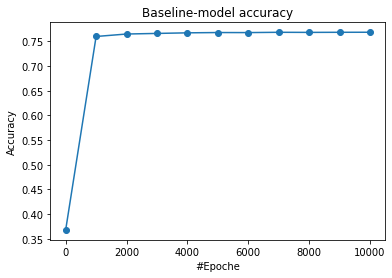

In [ ]:
plt.plot(BL_Epoch, BL_Test_accuracy, marker='o')
plt.title("Baseline-model accuracy")
plt.xlabel('#Epoche')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
import pandas as pd
d = {'epoch': Epoch, 'total_loss': Total_loss, 'pertubation_loss': Pertubation_loss, 
     'cross_entropy_loss': Cross_entropy_loss, 'test_accuracy': Test_accuracy}
df = pd.DataFrame(data = d)

In [ ]:
from google.colab import files
df.to_csv('vat.csv') 
files.download('vat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
small_df = df[0:200:10]

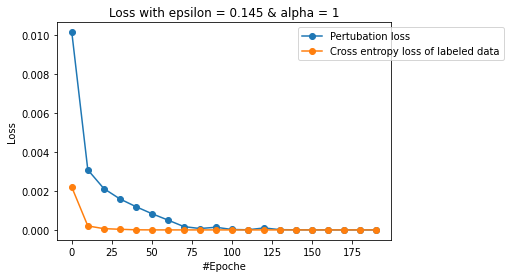

In [ ]:
plt.plot(small_df.epoch, small_df.pertubation_loss, marker='o', label='Pertubation loss')
plt.plot(small_df.epoch, small_df.cross_entropy_loss, marker='o', label='Cross entropy loss of labeled data')
plt.title("Loss with epsilon = 0.145 & alpha = 1")
plt.xlabel('#Epoche')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))
plt.show()

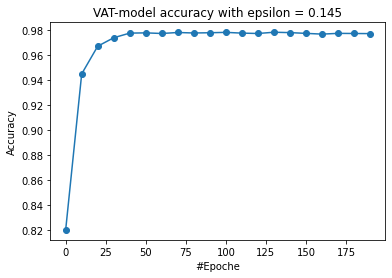

In [ ]:
plt.plot(small_df.epoch, small_df.test_accuracy, marker='o')
plt.title("VAT-model accuracy with epsilon = 0.145 & alpha = 1")
plt.xlabel('#Epoche')
plt.ylabel('Accuracy')
plt.show()